# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 46kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

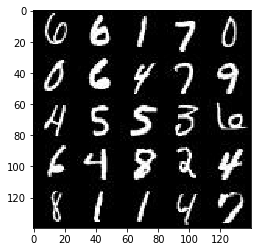

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

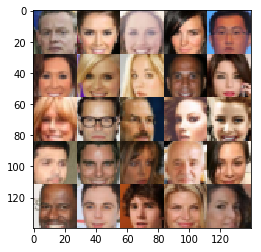

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name = 'real_input')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name = 'input_z')
    learning_rate = tf.placeholder(tf.float32)
    return real_input, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha = 0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse = reuse):
        x = tf.layers.conv2d(images,32, 5, strides = 2, padding = 'same', activation = None)
        x = tf.maximum(alpha*x,x)
        
        x = tf.layers.conv2d(x, 64, 5, strides = 2, padding = 'same', use_bias = None, activation = None)
        x = tf.layers.batch_normalization(x, training = True)
        x = tf.maximum(alpha*x,x)
        
        x = tf.layers.conv2d(x, 128, 5, strides = 2, padding = 'same', activation = None)
        x = tf.layers.batch_normalization(x, training = True)
        x = tf.maximum(alpha*x,x)
        
        x= tf.reshape(x, [-1, 4*4*128])
        logits = tf.layers.dense(x, 1, activation = None)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    if is_train == True:
        reuse = False
    else:
        reuse = True
        
    with tf.variable_scope("generator", reuse = reuse):
        
        
        #y1 = tf.layers.dense(z, 4*4*1024)
        #y1 = tf.maximum(alpha*y1, y1)
        
        y1 = tf.layers.dense(z, 7*7*256)
        y1 = tf.reshape(y1, (-1, 7, 7, 256))
        y1 = tf.layers.batch_normalization(y1, training = is_train)
        y1 = tf.maximum(alpha*y1, y1)
        
        y2 = tf.layers.conv2d_transpose(y1, 128, 5, strides = 2, padding = 'same')
        y2 = tf.layers.batch_normalization(y2, training = is_train)
        y2 = tf.maximum(alpha*y2, y2)
    
        
        #y = tf.layers.conv2transpose(y, 256, 3, strides = 2, padding = 'same', use_bias = None)
        #y = tf.layers.batch_normalization(y, is_train = True)
        #y = tf.maximum(alpha*y, y)
        
        logits = tf.layers.conv2d_transpose(y2, out_channel_dim, 5, strides = 2, padding = 'same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_train = False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha = 0.01):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    if data_image_mode == "RGB":
        color_channels = 3
    else:
        color_channels = 1
        
    input_real, input_z, l_r = model_inputs(data_shape[1], data_shape[1],color_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, color_channels, alpha=alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    show_every = 100
    print_every = 10
    steps = 0
    #sample_z = np.random.uniform(-0.5, 0.5, size=(72, z_dim))
    sample_z = tf.random_uniform(shape = [25, z_dim] , minval= -0.5, maxval= 0.5, dtype=tf.float32)
    #s_z = tf.placeholder(tf.float32, [None, z_dim])
    #s_z = sample_z
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                steps += 1
                batch_z = np.random.uniform(-0.5, 0.5, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps%show_every ==0:
                    show_generator_output(sess, 25, sample_z, color_channels, data_image_mode)
                

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5459... Generator Loss: 1.8530
Epoch 1/2... Discriminator Loss: 1.7023... Generator Loss: 5.4198
Epoch 1/2... Discriminator Loss: 0.7080... Generator Loss: 1.1530
Epoch 1/2... Discriminator Loss: 0.5399... Generator Loss: 2.5290
Epoch 1/2... Discriminator Loss: 0.8503... Generator Loss: 1.1867
Epoch 1/2... Discriminator Loss: 1.0695... Generator Loss: 0.6534
Epoch 1/2... Discriminator Loss: 1.0258... Generator Loss: 2.0212
Epoch 1/2... Discriminator Loss: 0.7882... Generator Loss: 1.1077
Epoch 1/2... Discriminator Loss: 0.7420... Generator Loss: 1.0947
Epoch 1/2... Discriminator Loss: 1.9702... Generator Loss: 0.1972


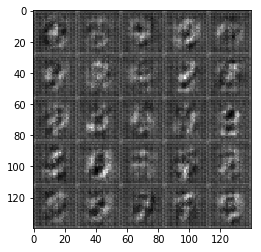

Epoch 1/2... Discriminator Loss: 0.6132... Generator Loss: 1.6071
Epoch 1/2... Discriminator Loss: 0.1990... Generator Loss: 2.9675
Epoch 1/2... Discriminator Loss: 0.5065... Generator Loss: 2.5142
Epoch 1/2... Discriminator Loss: 0.2591... Generator Loss: 2.3190
Epoch 1/2... Discriminator Loss: 0.3112... Generator Loss: 1.8321
Epoch 1/2... Discriminator Loss: 0.2351... Generator Loss: 2.3657
Epoch 1/2... Discriminator Loss: 0.2152... Generator Loss: 2.0205
Epoch 1/2... Discriminator Loss: 0.0623... Generator Loss: 4.2097
Epoch 1/2... Discriminator Loss: 0.2928... Generator Loss: 1.7553
Epoch 1/2... Discriminator Loss: 0.1916... Generator Loss: 2.9945


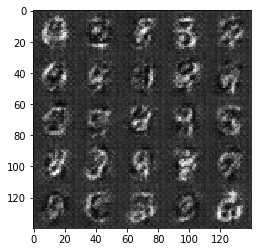

Epoch 1/2... Discriminator Loss: 0.0835... Generator Loss: 3.1975
Epoch 1/2... Discriminator Loss: 0.5955... Generator Loss: 1.0297
Epoch 1/2... Discriminator Loss: 0.3168... Generator Loss: 5.2811
Epoch 1/2... Discriminator Loss: 0.0843... Generator Loss: 3.4937
Epoch 1/2... Discriminator Loss: 0.4995... Generator Loss: 1.2136
Epoch 1/2... Discriminator Loss: 0.0788... Generator Loss: 5.3124
Epoch 1/2... Discriminator Loss: 0.0962... Generator Loss: 3.1895
Epoch 1/2... Discriminator Loss: 2.0470... Generator Loss: 6.7192
Epoch 1/2... Discriminator Loss: 0.5248... Generator Loss: 1.8190
Epoch 1/2... Discriminator Loss: 0.3527... Generator Loss: 1.7528


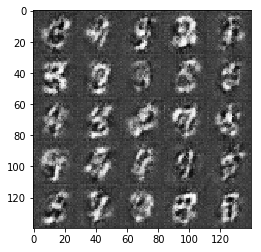

Epoch 1/2... Discriminator Loss: 0.1661... Generator Loss: 2.4268
Epoch 1/2... Discriminator Loss: 0.1303... Generator Loss: 4.0086
Epoch 1/2... Discriminator Loss: 0.2811... Generator Loss: 3.6337
Epoch 1/2... Discriminator Loss: 0.3405... Generator Loss: 4.3992
Epoch 1/2... Discriminator Loss: 0.7039... Generator Loss: 0.8785
Epoch 1/2... Discriminator Loss: 0.2088... Generator Loss: 2.2522
Epoch 1/2... Discriminator Loss: 0.2942... Generator Loss: 1.8158
Epoch 1/2... Discriminator Loss: 0.1053... Generator Loss: 3.0893
Epoch 1/2... Discriminator Loss: 0.5449... Generator Loss: 1.1728
Epoch 1/2... Discriminator Loss: 0.3955... Generator Loss: 1.7332


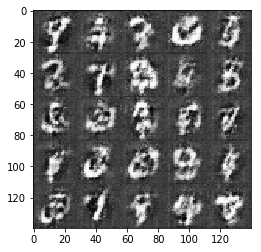

Epoch 1/2... Discriminator Loss: 0.3780... Generator Loss: 1.9019
Epoch 1/2... Discriminator Loss: 0.2477... Generator Loss: 2.4632
Epoch 1/2... Discriminator Loss: 0.1794... Generator Loss: 2.6489
Epoch 1/2... Discriminator Loss: 0.1228... Generator Loss: 2.8143
Epoch 1/2... Discriminator Loss: 0.1256... Generator Loss: 3.1741
Epoch 1/2... Discriminator Loss: 0.2247... Generator Loss: 2.0382
Epoch 2/2... Discriminator Loss: 0.5261... Generator Loss: 5.1141
Epoch 2/2... Discriminator Loss: 0.3801... Generator Loss: 1.7370
Epoch 2/2... Discriminator Loss: 0.3793... Generator Loss: 1.6182
Epoch 2/2... Discriminator Loss: 0.1725... Generator Loss: 2.5111


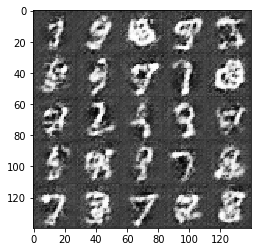

Epoch 2/2... Discriminator Loss: 0.1175... Generator Loss: 3.1000
Epoch 2/2... Discriminator Loss: 0.1819... Generator Loss: 4.2056
Epoch 2/2... Discriminator Loss: 0.1958... Generator Loss: 5.0055
Epoch 2/2... Discriminator Loss: 0.2117... Generator Loss: 3.5928
Epoch 2/2... Discriminator Loss: 0.1071... Generator Loss: 4.0910
Epoch 2/2... Discriminator Loss: 1.2497... Generator Loss: 0.5549
Epoch 2/2... Discriminator Loss: 0.2884... Generator Loss: 1.9045
Epoch 2/2... Discriminator Loss: 0.2883... Generator Loss: 1.8766
Epoch 2/2... Discriminator Loss: 0.3138... Generator Loss: 1.8088
Epoch 2/2... Discriminator Loss: 0.1841... Generator Loss: 2.5375


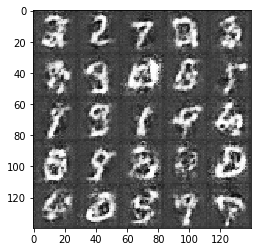

Epoch 2/2... Discriminator Loss: 0.2608... Generator Loss: 2.0074
Epoch 2/2... Discriminator Loss: 0.1452... Generator Loss: 3.3020
Epoch 2/2... Discriminator Loss: 0.0618... Generator Loss: 3.7742
Epoch 2/2... Discriminator Loss: 0.2499... Generator Loss: 2.2217
Epoch 2/2... Discriminator Loss: 0.2700... Generator Loss: 1.9426
Epoch 2/2... Discriminator Loss: 0.2293... Generator Loss: 2.1556
Epoch 2/2... Discriminator Loss: 0.2277... Generator Loss: 2.1705
Epoch 2/2... Discriminator Loss: 0.2032... Generator Loss: 2.2427
Epoch 2/2... Discriminator Loss: 0.1286... Generator Loss: 2.8152
Epoch 2/2... Discriminator Loss: 0.1361... Generator Loss: 2.5995


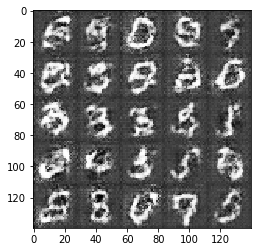

Epoch 2/2... Discriminator Loss: 0.2561... Generator Loss: 1.8708
Epoch 2/2... Discriminator Loss: 0.0338... Generator Loss: 4.4480
Epoch 2/2... Discriminator Loss: 0.0291... Generator Loss: 4.7668
Epoch 2/2... Discriminator Loss: 0.0686... Generator Loss: 3.6288
Epoch 2/2... Discriminator Loss: 0.5571... Generator Loss: 7.5514
Epoch 2/2... Discriminator Loss: 1.0467... Generator Loss: 0.8308
Epoch 2/2... Discriminator Loss: 0.5336... Generator Loss: 1.5365
Epoch 2/2... Discriminator Loss: 0.4365... Generator Loss: 1.7368
Epoch 2/2... Discriminator Loss: 0.5479... Generator Loss: 1.1436
Epoch 2/2... Discriminator Loss: 0.2990... Generator Loss: 1.9968


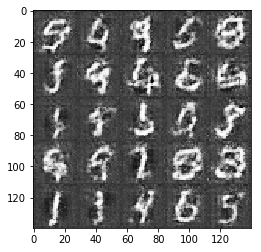

Epoch 2/2... Discriminator Loss: 0.2467... Generator Loss: 1.9073
Epoch 2/2... Discriminator Loss: 0.4976... Generator Loss: 1.1378
Epoch 2/2... Discriminator Loss: 0.1266... Generator Loss: 2.9156
Epoch 2/2... Discriminator Loss: 0.3336... Generator Loss: 3.9205
Epoch 2/2... Discriminator Loss: 0.1300... Generator Loss: 2.6469
Epoch 2/2... Discriminator Loss: 0.1402... Generator Loss: 2.6024
Epoch 2/2... Discriminator Loss: 0.0992... Generator Loss: 2.8998
Epoch 2/2... Discriminator Loss: 1.0525... Generator Loss: 0.5769
Epoch 2/2... Discriminator Loss: 0.1619... Generator Loss: 2.7090
Epoch 2/2... Discriminator Loss: 0.0668... Generator Loss: 4.5629


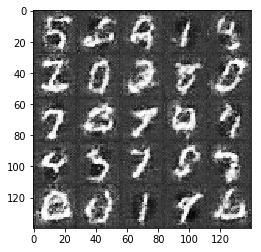

Epoch 2/2... Discriminator Loss: 0.1129... Generator Loss: 3.2865
Epoch 2/2... Discriminator Loss: 5.6206... Generator Loss: 8.9387
Epoch 2/2... Discriminator Loss: 0.5087... Generator Loss: 1.3201


In [19]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.6360... Generator Loss: 0.3577
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.4377
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.5319
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 0.7612... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 0.7561... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 0.5943... Generator Loss: 1.2046
Epoch 1/1... Discriminator Loss: 0.4982... Generator Loss: 1.3558
Epoch 1/1... Discriminator Loss: 0.6152... Generator Loss: 1.2149


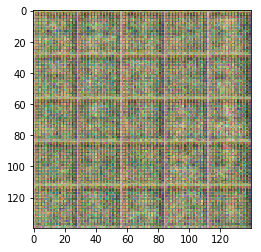

Epoch 1/1... Discriminator Loss: 0.5973... Generator Loss: 1.4128
Epoch 1/1... Discriminator Loss: 0.6971... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 0.4905... Generator Loss: 1.6109
Epoch 1/1... Discriminator Loss: 0.5682... Generator Loss: 1.5357
Epoch 1/1... Discriminator Loss: 0.7825... Generator Loss: 0.9751
Epoch 1/1... Discriminator Loss: 0.9231... Generator Loss: 0.9333
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 0.9524
Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 0.8065... Generator Loss: 0.9472


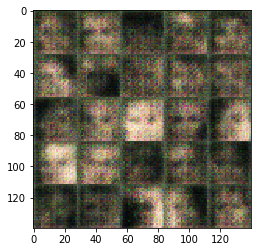

Epoch 1/1... Discriminator Loss: 0.7200... Generator Loss: 1.1713
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 0.8025... Generator Loss: 1.0501
Epoch 1/1... Discriminator Loss: 0.8194... Generator Loss: 1.2209
Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 0.9213... Generator Loss: 1.2465
Epoch 1/1... Discriminator Loss: 0.9446... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 1.0414
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 0.8429


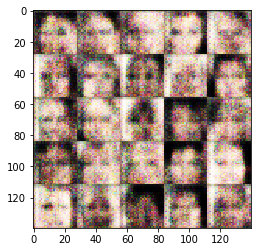

Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 0.9196
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 1.0975
Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 1.0007
Epoch 1/1... Discriminator Loss: 0.8926... Generator Loss: 1.1393
Epoch 1/1... Discriminator Loss: 0.8012... Generator Loss: 1.2188
Epoch 1/1... Discriminator Loss: 0.7371... Generator Loss: 1.1017
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 0.8652


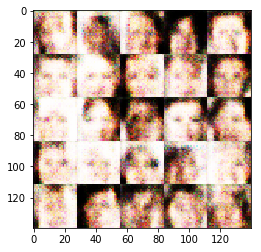

Epoch 1/1... Discriminator Loss: 0.7757... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 0.8283... Generator Loss: 1.2010
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 0.9419... Generator Loss: 1.0810
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 1.0069
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 1.0362
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 0.8901


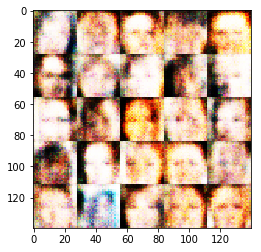

Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 0.8749... Generator Loss: 0.9943
Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 0.7502... Generator Loss: 1.2788
Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 1.0767
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 1.1498


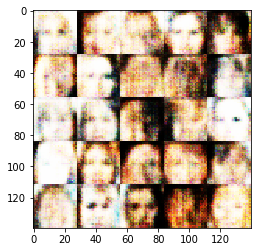

Epoch 1/1... Discriminator Loss: 0.7301... Generator Loss: 1.3257
Epoch 1/1... Discriminator Loss: 0.7792... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 0.5626... Generator Loss: 1.5489
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 0.8632... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 0.7303... Generator Loss: 1.1750
Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 0.9481... Generator Loss: 0.9196
Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 0.8612


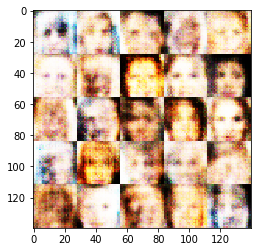

Epoch 1/1... Discriminator Loss: 0.7602... Generator Loss: 1.2464
Epoch 1/1... Discriminator Loss: 0.7089... Generator Loss: 0.9865
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 1.2185
Epoch 1/1... Discriminator Loss: 0.7340... Generator Loss: 1.1177
Epoch 1/1... Discriminator Loss: 0.8874... Generator Loss: 0.9988
Epoch 1/1... Discriminator Loss: 0.7277... Generator Loss: 1.3775
Epoch 1/1... Discriminator Loss: 0.5992... Generator Loss: 1.2557
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 0.7957... Generator Loss: 1.1469


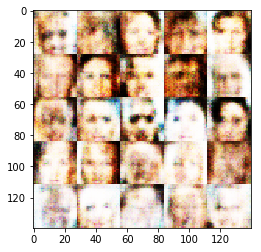

Epoch 1/1... Discriminator Loss: 0.8063... Generator Loss: 1.0532
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 1.0766
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 0.8224... Generator Loss: 1.0117
Epoch 1/1... Discriminator Loss: 0.8012... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.9642
Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.7162


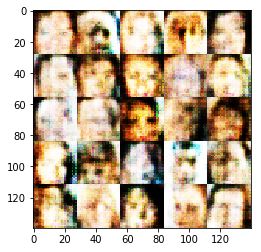

Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 0.9303
Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 1.0235
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 0.9294
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 1.1629
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.5462


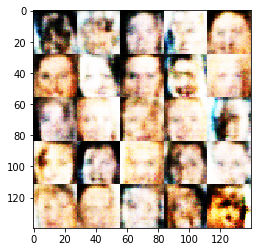

Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.7502


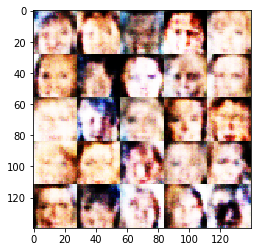

Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.9718
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 0.9643
Epoch 1/1... Discriminator Loss: 0.9288... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 0.7010


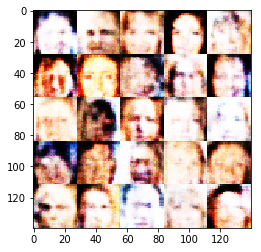

Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.4283
Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 1.3590
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.5138
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 0.9923
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 0.8736


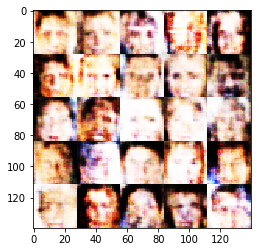

Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 1.2394
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 0.8455


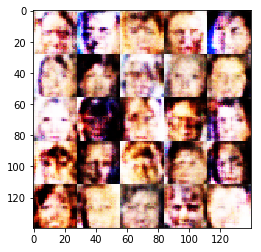

Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 1.1660
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.4706
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.4338
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 1.0015
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 0.7531


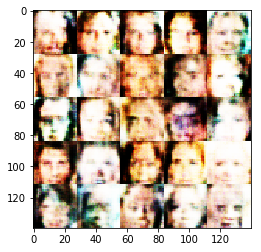

Epoch 1/1... Discriminator Loss: 0.9059... Generator Loss: 1.0526
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 1.1722
Epoch 1/1... Discriminator Loss: 0.7809... Generator Loss: 1.3482
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 1.0100
Epoch 1/1... Discriminator Loss: 1.5484... Generator Loss: 0.3994


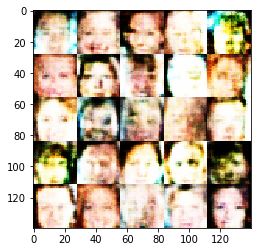

Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 0.7104... Generator Loss: 1.3096
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 1.0053
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.5338
Epoch 1/1... Discriminator Loss: 0.6435... Generator Loss: 1.5799
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.7061


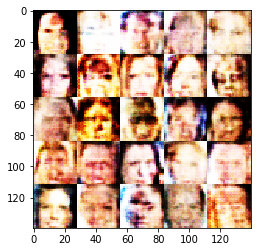

Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 1.0157
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 1.1746
Epoch 1/1... Discriminator Loss: 0.8775... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 1.0689
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 0.8257


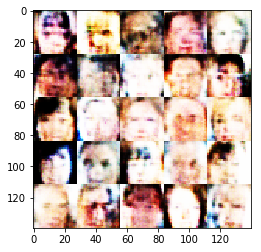

Epoch 1/1... Discriminator Loss: 0.9267... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 0.9519
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 0.8836... Generator Loss: 1.0679
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.9287... Generator Loss: 0.2120


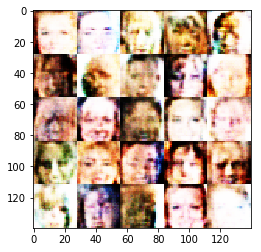

Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 1.2441
Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 1.2606
Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 1.6039
Epoch 1/1... Discriminator Loss: 0.6558... Generator Loss: 1.0849
Epoch 1/1... Discriminator Loss: 0.8661... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 1.6099... Generator Loss: 0.3532
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 0.9127
Epoch 1/1... Discriminator Loss: 0.8114... Generator Loss: 1.2665


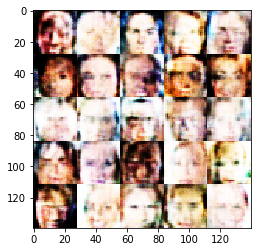

Epoch 1/1... Discriminator Loss: 0.7675... Generator Loss: 1.6619
Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 1.1753
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 1.1441
Epoch 1/1... Discriminator Loss: 0.8341... Generator Loss: 0.9624
Epoch 1/1... Discriminator Loss: 1.6354... Generator Loss: 0.3196
Epoch 1/1... Discriminator Loss: 0.9088... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 1.2068
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.6399


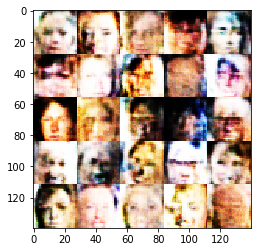

Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 0.9658
Epoch 1/1... Discriminator Loss: 0.6628... Generator Loss: 1.5067
Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 1.8815
Epoch 1/1... Discriminator Loss: 0.7692... Generator Loss: 1.0764
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 0.6707... Generator Loss: 1.4136
Epoch 1/1... Discriminator Loss: 0.5182... Generator Loss: 1.8678
Epoch 1/1... Discriminator Loss: 0.7336... Generator Loss: 1.6531
Epoch 1/1... Discriminator Loss: 0.7385... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 1.5495... Generator Loss: 0.4214


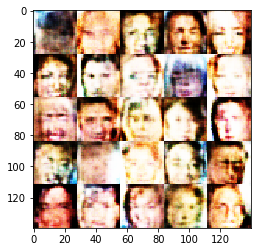

Epoch 1/1... Discriminator Loss: 0.6930... Generator Loss: 1.0846
Epoch 1/1... Discriminator Loss: 1.6037... Generator Loss: 0.3620
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.5158
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.5741
Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 0.3638
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.4075
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.4570
Epoch 1/1... Discriminator Loss: 0.9094... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.5262... Generator Loss: 0.3731
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 0.9034


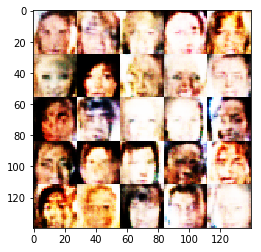

Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 1.0693
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.0014... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 0.8795... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.5364
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.6659


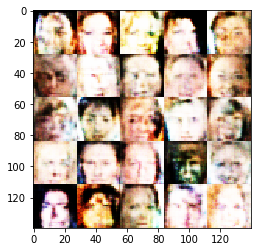

Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 1.0839
Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 0.9431
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.6146... Generator Loss: 0.4294
Epoch 1/1... Discriminator Loss: 0.9248... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 0.8838


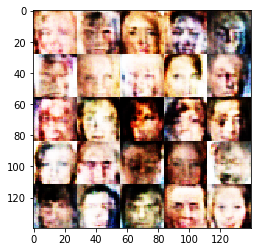

Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.0292... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 0.9015... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 0.6158... Generator Loss: 1.2863


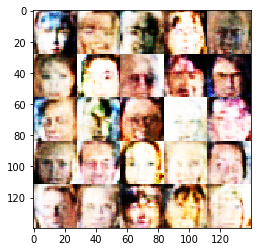

Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 1.3531
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 0.9640... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.5367
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.4635
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.8234


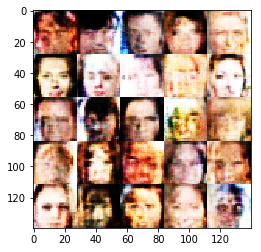

Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 0.9633
Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.6991


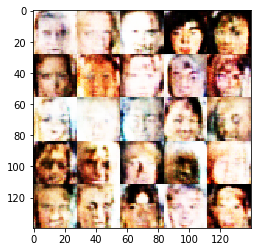

Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 0.9861
Epoch 1/1... Discriminator Loss: 0.7337... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 0.9049


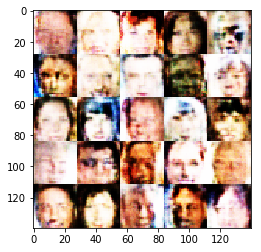

Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 0.9119
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 0.7589... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.4332
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.5604... Generator Loss: 0.5054
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.6722


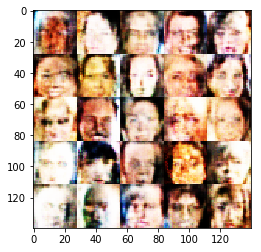

Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.7917... Generator Loss: 0.3830
Epoch 1/1... Discriminator Loss: 0.8244... Generator Loss: 1.1155
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 1.0206
Epoch 1/1... Discriminator Loss: 0.7231... Generator Loss: 1.0253
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.5286
Epoch 1/1... Discriminator Loss: 0.6018... Generator Loss: 1.2977
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 0.8569


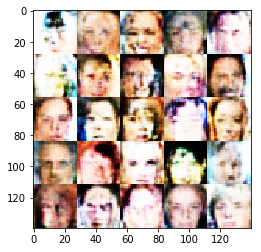

Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 0.9589... Generator Loss: 1.0889
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.9471
Epoch 1/1... Discriminator Loss: 0.9084... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 0.7065... Generator Loss: 1.0777


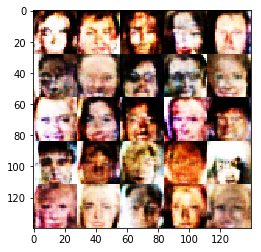

Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 0.6804... Generator Loss: 1.3057
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.5290
Epoch 1/1... Discriminator Loss: 0.6554... Generator Loss: 1.4318
Epoch 1/1... Discriminator Loss: 1.5342... Generator Loss: 0.4623
Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 0.9380


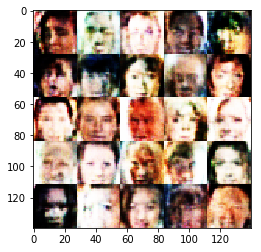

Epoch 1/1... Discriminator Loss: 0.9220... Generator Loss: 1.1783
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.5538
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.6257... Generator Loss: 0.3115
Epoch 1/1... Discriminator Loss: 1.5159... Generator Loss: 0.3575
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 0.5568... Generator Loss: 1.5779
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.6163


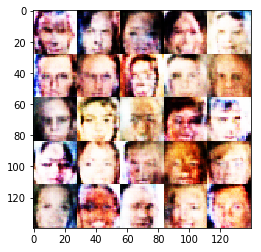

Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 0.5299... Generator Loss: 2.1251
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 0.3716... Generator Loss: 2.4291
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 1.5987... Generator Loss: 0.4352
Epoch 1/1... Discriminator Loss: 1.8371... Generator Loss: 0.2922
Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 0.7970


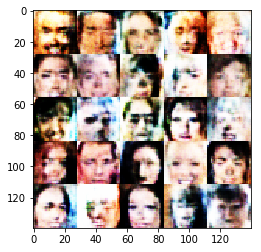

Epoch 1/1... Discriminator Loss: 0.4537... Generator Loss: 2.3245
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 0.7846... Generator Loss: 1.5251
Epoch 1/1... Discriminator Loss: 0.8426... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.4110
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 2.0967... Generator Loss: 0.2274
Epoch 1/1... Discriminator Loss: 0.3660... Generator Loss: 2.4304
Epoch 1/1... Discriminator Loss: 0.8138... Generator Loss: 0.7735


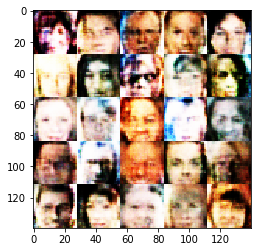

Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 0.2838... Generator Loss: 1.9351
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.3939
Epoch 1/1... Discriminator Loss: 1.6807... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.3823
Epoch 1/1... Discriminator Loss: 0.8445... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.3616
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 0.6070... Generator Loss: 1.6662
Epoch 1/1... Discriminator Loss: 0.5554... Generator Loss: 1.3604


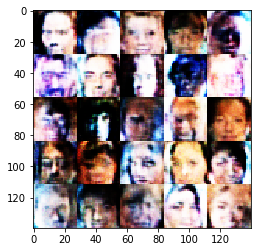

Epoch 1/1... Discriminator Loss: 0.4608... Generator Loss: 1.8358
Epoch 1/1... Discriminator Loss: 0.7269... Generator Loss: 1.2105
Epoch 1/1... Discriminator Loss: 0.2556... Generator Loss: 2.9773
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.3932
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 1.0255
Epoch 1/1... Discriminator Loss: 0.4542... Generator Loss: 1.8965
Epoch 1/1... Discriminator Loss: 0.2557... Generator Loss: 3.8502
Epoch 1/1... Discriminator Loss: 0.2481... Generator Loss: 3.1788
Epoch 1/1... Discriminator Loss: 0.8070... Generator Loss: 0.9756
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 0.6384


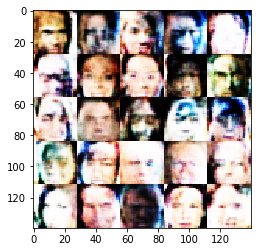

Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 2.0225
Epoch 1/1... Discriminator Loss: 1.5982... Generator Loss: 0.3708
Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 0.5709
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.4595
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.4853
Epoch 1/1... Discriminator Loss: 0.7173... Generator Loss: 1.2359
Epoch 1/1... Discriminator Loss: 0.7967... Generator Loss: 1.5576


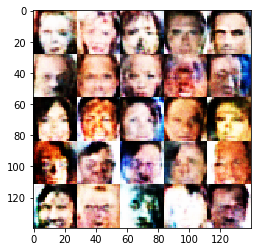

Epoch 1/1... Discriminator Loss: 0.6316... Generator Loss: 1.2482
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 0.9465
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.5141
Epoch 1/1... Discriminator Loss: 0.4697... Generator Loss: 1.4011
Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.4487
Epoch 1/1... Discriminator Loss: 0.7542... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 0.3335
Epoch 1/1... Discriminator Loss: 2.7378... Generator Loss: 0.0940


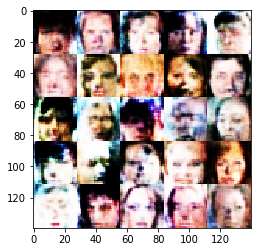

Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 1.0908
Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.5381
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 2.2800... Generator Loss: 0.1387
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 0.9033... Generator Loss: 1.3535
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.5490
Epoch 1/1... Discriminator Loss: 0.5969... Generator Loss: 1.1664


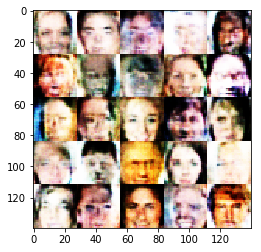

Epoch 1/1... Discriminator Loss: 0.8034... Generator Loss: 1.1350
Epoch 1/1... Discriminator Loss: 0.6092... Generator Loss: 0.9864
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 0.5638... Generator Loss: 1.3455
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 1.0850
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 0.4189... Generator Loss: 2.3733
Epoch 1/1... Discriminator Loss: 0.5551... Generator Loss: 1.4650
Epoch 1/1... Discriminator Loss: 0.6134... Generator Loss: 1.4756
Epoch 1/1... Discriminator Loss: 0.2853... Generator Loss: 2.0951


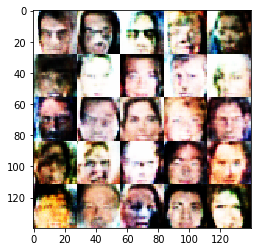

Epoch 1/1... Discriminator Loss: 1.6341... Generator Loss: 0.5208
Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 1.2988
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 0.5886... Generator Loss: 2.4075
Epoch 1/1... Discriminator Loss: 0.6821... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 0.5604... Generator Loss: 1.6071
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 1.1221
Epoch 1/1... Discriminator Loss: 0.6451... Generator Loss: 1.7035


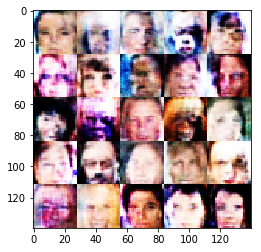

Epoch 1/1... Discriminator Loss: 0.7270... Generator Loss: 1.4215
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 0.8373... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 1.2072
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.6161
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 1.2374
Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 0.9998
Epoch 1/1... Discriminator Loss: 0.9188... Generator Loss: 1.0074
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.5659
Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 0.7655


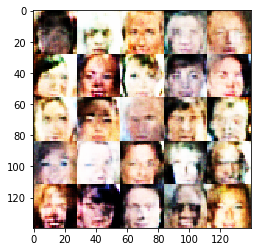

Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.9311
Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 1.0373
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 0.6469... Generator Loss: 0.9104
Epoch 1/1... Discriminator Loss: 0.4231... Generator Loss: 2.2598
Epoch 1/1... Discriminator Loss: 0.6137... Generator Loss: 1.5893
Epoch 1/1... Discriminator Loss: 0.5572... Generator Loss: 1.8264
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.5308


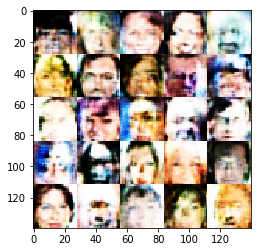

Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.4417
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 1.3140
Epoch 1/1... Discriminator Loss: 0.2616... Generator Loss: 3.1450
Epoch 1/1... Discriminator Loss: 0.9807... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 0.8657... Generator Loss: 1.0982
Epoch 1/1... Discriminator Loss: 1.5823... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 0.7566... Generator Loss: 1.1190
Epoch 1/1... Discriminator Loss: 0.4273... Generator Loss: 2.3047
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.5176


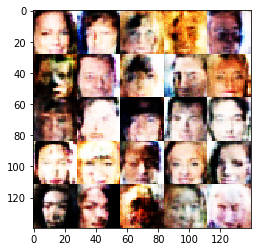

Epoch 1/1... Discriminator Loss: 0.7131... Generator Loss: 1.7841
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 0.5808... Generator Loss: 2.3085
Epoch 1/1... Discriminator Loss: 0.3198... Generator Loss: 3.7589
Epoch 1/1... Discriminator Loss: 0.8632... Generator Loss: 1.1931
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 1.1016
Epoch 1/1... Discriminator Loss: 2.0121... Generator Loss: 0.2075
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 0.7349... Generator Loss: 1.0886


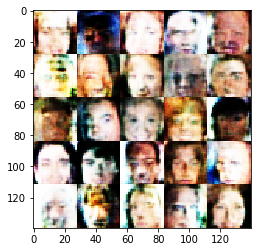

Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 1.1007
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 0.4702
Epoch 1/1... Discriminator Loss: 0.4788... Generator Loss: 1.3750
Epoch 1/1... Discriminator Loss: 0.5510... Generator Loss: 1.6427
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 0.6722... Generator Loss: 1.1358
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.6796


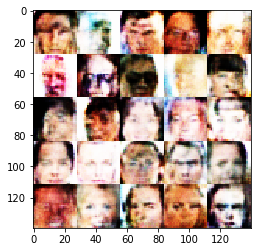

Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 0.8888... Generator Loss: 0.9932
Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 0.9132


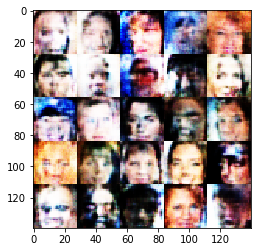

Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 1.1342
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 1.0098
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 1.1646
Epoch 1/1... Discriminator Loss: 0.9520... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 1.8410... Generator Loss: 0.4855
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.5200


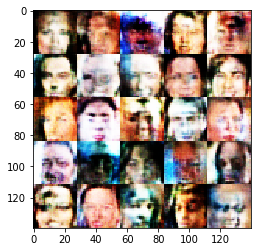

Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 0.9054... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.7600


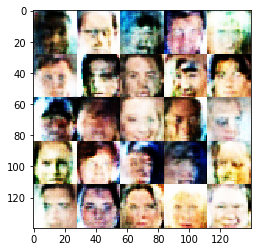

Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 0.8531... Generator Loss: 1.1142
Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 0.9163
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 0.8867... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 0.9136


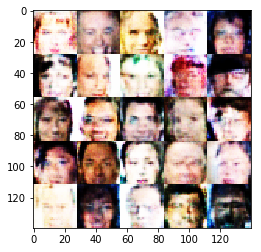

Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 0.8393... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 0.8085... Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 0.2436... Generator Loss: 2.6025
Epoch 1/1... Discriminator Loss: 0.7371... Generator Loss: 0.9513
Epoch 1/1... Discriminator Loss: 0.6263... Generator Loss: 0.9835
Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 0.1905... Generator Loss: 2.4562


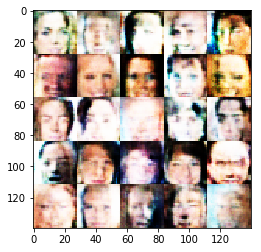

Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 1.4931
Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 0.9450
Epoch 1/1... Discriminator Loss: 0.7642... Generator Loss: 1.2087
Epoch 1/1... Discriminator Loss: 0.9887... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 0.3647... Generator Loss: 2.8479
Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.4552


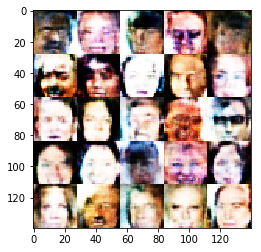

Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.4250
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 0.9823
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 0.4386... Generator Loss: 1.9438
Epoch 1/1... Discriminator Loss: 0.8307... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 0.6031... Generator Loss: 1.2015
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.4530
Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.6568


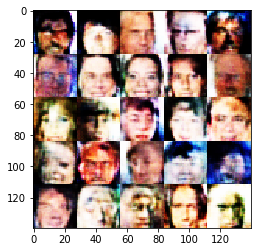

Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 0.9184... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 0.4937... Generator Loss: 2.2046
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.5535
Epoch 1/1... Discriminator Loss: 1.5850... Generator Loss: 0.4538
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 0.3936... Generator Loss: 3.2429
Epoch 1/1... Discriminator Loss: 0.8054... Generator Loss: 0.7829


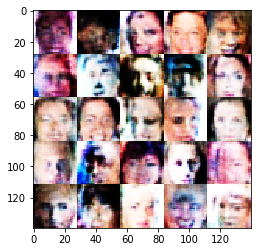

Epoch 1/1... Discriminator Loss: 0.7529... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 0.2160... Generator Loss: 2.5647
Epoch 1/1... Discriminator Loss: 0.7671... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 0.2062... Generator Loss: 1.9725
Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 1.6927
Epoch 1/1... Discriminator Loss: 0.9833... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 1.0666
Epoch 1/1... Discriminator Loss: 0.4827... Generator Loss: 1.4787
Epoch 1/1... Discriminator Loss: 0.7005... Generator Loss: 1.3525
Epoch 1/1... Discriminator Loss: 0.4042... Generator Loss: 2.2988


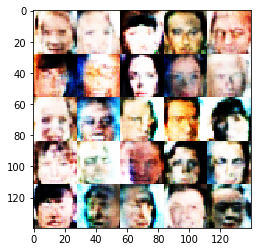

Epoch 1/1... Discriminator Loss: 0.1802... Generator Loss: 3.1324
Epoch 1/1... Discriminator Loss: 0.2298... Generator Loss: 2.1365
Epoch 1/1... Discriminator Loss: 1.8384... Generator Loss: 0.2145
Epoch 1/1... Discriminator Loss: 0.2145... Generator Loss: 2.8493
Epoch 1/1... Discriminator Loss: 0.6183... Generator Loss: 1.4722
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.3584
Epoch 1/1... Discriminator Loss: 2.2223... Generator Loss: 0.2813
Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 0.6773... Generator Loss: 1.4906
Epoch 1/1... Discriminator Loss: 0.2268... Generator Loss: 2.8014


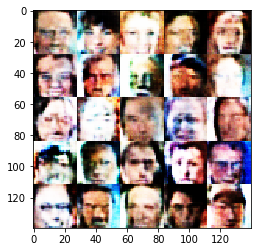

Epoch 1/1... Discriminator Loss: 0.5162... Generator Loss: 1.8103
Epoch 1/1... Discriminator Loss: 0.7827... Generator Loss: 3.0243
Epoch 1/1... Discriminator Loss: 0.1779... Generator Loss: 3.8943
Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 3.7032
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 0.5468
Epoch 1/1... Discriminator Loss: 0.6961... Generator Loss: 1.4126
Epoch 1/1... Discriminator Loss: 0.5301... Generator Loss: 1.2333
Epoch 1/1... Discriminator Loss: 0.2493... Generator Loss: 3.2138
Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 1.6701
Epoch 1/1... Discriminator Loss: 0.2624... Generator Loss: 2.4304


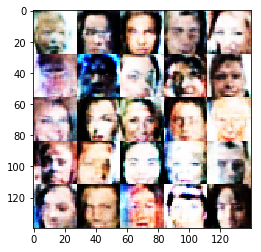

Epoch 1/1... Discriminator Loss: 0.5991... Generator Loss: 1.2315
Epoch 1/1... Discriminator Loss: 0.7821... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 0.1877... Generator Loss: 3.3660
Epoch 1/1... Discriminator Loss: 0.2490... Generator Loss: 2.3318
Epoch 1/1... Discriminator Loss: 0.3871... Generator Loss: 2.0614
Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 1.1721
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.4954
Epoch 1/1... Discriminator Loss: 0.1334... Generator Loss: 2.4588
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 0.7987


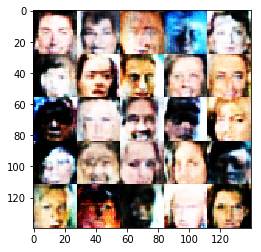

Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.7215... Generator Loss: 0.4833
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.0051... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 0.7987... Generator Loss: 0.9398


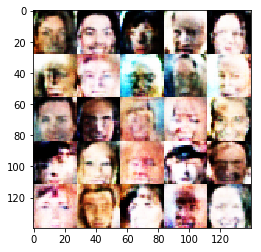

Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.5591
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 1.0351
Epoch 1/1... Discriminator Loss: 1.5571... Generator Loss: 0.4656


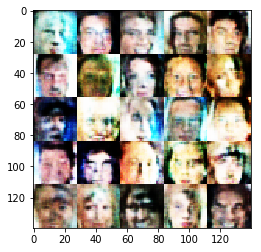

Epoch 1/1... Discriminator Loss: 0.7781... Generator Loss: 0.8823
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 1.0866
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 1.1568
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 0.7842


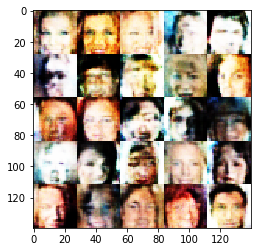

Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 0.7830... Generator Loss: 1.0422


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.